# Ejercicio 6: Teorema de Bayes

_Continuación de los dos ejercicios anteriores, pero añadiendo priors para aplicar el teorema de Bayes._

La _distancia-módulo $ \mu $_ está dada por la expresión

$$
\mu = 25 - 5\log_{10}(H_0/100) + 5\log_{10}(D_L/Mpc)
$$

donde $ H_0 $ es la constante de Hubble y

$$
D_L = \frac{c}{H_0}(1 + z)[\eta(1, \Omega_m) - \eta(1/(1 + z), \Omega_m)]
$$

es la _distancia luminosa_. Aquí, $ c $ es la velocidad de la luz, $ z $ es el corrimiento al rojo, $ \Omega_m $ es la densidad de masa bariónica mas materia oscura y

$$
\eta(a, \Omega_m) = 2\sqrt{s^3 + 1}[a^{-4} - 0.1540sa^{-3} + 0.4304s^2a^{-2} + 0.19097s^3a^{-1} + 0.066941s^4]^{-1/8}
$$

$$
s^3 = (1 - \Omega_m)/\Omega_m
$$

Lo que buscamos es maximizar la función _Likelihood $ L $_, o su logaritmo. Asumiendo una distribución gaussiana:

$$
ln(L(\vec{x}, \vec{y} | \vec{\theta})) = -\frac{1}{2} \sum_{i} \Bigg(\frac{(y_i - \lambda(x_i, \vec{\theta}))^2}{\sigma_i^2}\Bigg)
$$

Donde $ \lambda(x, \vec{\theta}) $ es nuestro modelo propuesto. El algoritmo Metropolis consiste en dar _pasos_ aleatorios en el espacio de solución hasta encontrar una $ \lambda(x, \vec{\theta}) $ que maximice el likelihood.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, gauss
from pylab import rcParams
from math import exp

%matplotlib inline
rcParams['figure.figsize'] = (10, 6)

Text(0,0.5,'$\\mu$')

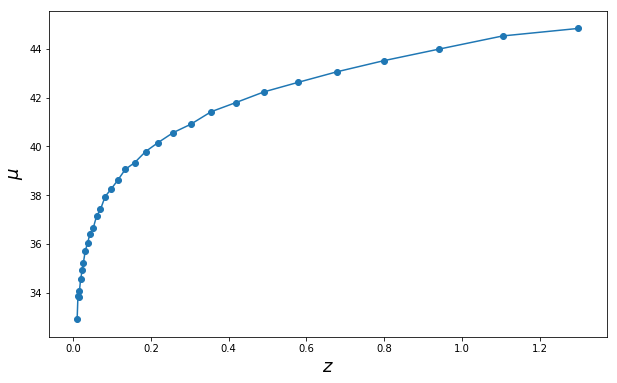

In [11]:
# Extraer datos desde archivos
cov_matrix = np.loadtxt('files/jla_mub_covmatrix.dat')
z = np.loadtxt('files/jla_mub.txt', usecols = 0)
mu = np.loadtxt('files/jla_mub.txt', usecols = 1)
varianza = []

# De cov_matrix solo nos interesa la varianza, que está en la diagonal
for i in range(31):
    varianza.append(cov_matrix[31 * i + i])
    
varianza = np.array(varianza)
    
plt.plot(z, mu)
plt.scatter(z, mu)
plt.xlabel(r'$z$', fontsize = 18)
plt.ylabel(r'$\mu$', fontsize = 18)

In [3]:
def s_func(omega_m):
    return pow((1.0 - omega_m) / omega_m, 1.0 / 3.0)

In [54]:
def eta(a, omega_m):
    s = s_func(omega_m)
    s2 = s**2.0
    s3 = s**3.0
    s4 = s2**2.0
    coef = [-0.154, 0.4304, 0.19097, 0.066941]
    
    return 2.0 * np.sqrt(s3 + 1.0) * pow(1.0/a**4.0 + coef[0]*s/a**3.0 + coef[1]*s2/a**2.0 + \
           coef[2]*s3/a + coef[3]*s4, -1.0/8.0)

In [55]:
def D_L(z, H_0, omega_m):
    c = 3.0e5 # km/s
    a0 = 1.0
    a1 = 1.0 / (1.0 + z)
    
    return c * (1.0 + z) * (eta(a0, omega_m) - eta(a1, omega_m)) / H_0

In [6]:
def dist_mu(z, H_0, omega_m):
    return 25.0 - 5.0 * np.log10(H_0 / 100.0) + 5.0 * np.log10(D_L(z, H_0, omega_m))

In [7]:
def log_like(H_0, omega_m, mu_arr, z_arr, var_arr): # ln(L)
    suma = np.sum(((mu_arr - dist_mu(z_arr, H_0, omega_m)) / var_arr)**2.0)
    return -0.5 * suma

In [74]:
Nsamples = 10000
omega_sample = []
h_sample = []
h0 = 51.0
omega0 = 0.3
old_like = log_like(h0, omega0, mu, z, varianza)
new_like = 0.0
accept_prob = 0.01 # Pa' la ruleta
sigma1 = 1.0 # Para h
sigma2 = 0.1 # Para omega

for i in range(Nsamples):
    h_sample.append(h0)
    omega_sample.append(omega0)
    
    h = -1.0
    omega = -1.0
    
    # Estos ciclos son para moverse cerca de la muestra
    # sin que se salgan del rango.
    while(h < 0 or h > 100):
        h = gauss(h0, sigma1)
    while(omega < 0.1 or omega > 1.0):
        omega = gauss(omega0, sigma2)
    
    new_like = log_like(h, omega, mu, z, varianza)
        
    if new_like > old_like:
        old_like = new_like
        h0 = h
        omega0 = omega
    elif random() < accept_prob:
        old_like = new_like
        h0 = h
        omega0 = omega

Text(0.5,1,'Valores de $H_0$ y $\\Omega_m$ utilizados')

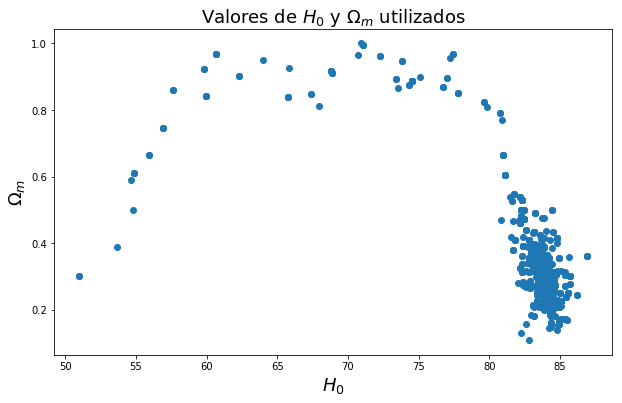

In [75]:
plt.plot(h_sample, omega_sample, 'o')
plt.xlabel(r'$H_0$', fontsize = 18)
plt.ylabel(r'$\Omega_m$', fontsize = 18)
plt.title(r'Valores de $H_0$ y $\Omega_m$ utilizados', fontsize = 18)